**Note: Use Python 3.9.0 Kernel, since "batchgenerators" and "nnunetv2" were installed via pip in this kernel itself and are not being installed in the 3.12.0 kernel due to some issues**

In [1]:
# nnUNet Training Pipeline for Histopathology Segmentation
# =========================================================
# Uses ResidualEncoderUNet from dynamic_network_architectures with deep supervision

import sys
import torch
import torch.nn as nn
import numpy as np
import warnings
import importlib
import pkgutil
import pydoc
from typing import Union

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
# !pip install batchgenerators
# !pip install nnunetv2

In [3]:
# nnUNet Model Setup Functions
from batchgenerators.utilities.file_and_folder_operations import join
import dynamic_network_architectures

def recursive_find_python_class(folder: str, class_name: str, current_module: str):
    tr = None
    for importer, modname, ispkg in pkgutil.iter_modules([folder]):
        if not ispkg:
            m = importlib.import_module(current_module + "." + modname)
            if hasattr(m, class_name):
                tr = getattr(m, class_name)
                break

    if tr is None:
        for importer, modname, ispkg in pkgutil.iter_modules([folder]):
            if ispkg:
                next_current_module = current_module + "." + modname
                tr = recursive_find_python_class(join(folder, modname), class_name, current_module=next_current_module)
            if tr is not None:
                break
    return tr

def get_network_from_plans(arch_class_name, arch_kwargs, arch_kwargs_req_import, input_channels, output_channels,
                           allow_init=True, deep_supervision: Union[bool, None] = None):
    network_class = arch_class_name
    architecture_kwargs = dict(**arch_kwargs)
    for ri in arch_kwargs_req_import:
        if architecture_kwargs[ri] is not None:
            architecture_kwargs[ri] = pydoc.locate(architecture_kwargs[ri])

    nw_class = pydoc.locate(network_class)
    if nw_class is None:
        warnings.warn(f'Network class {network_class} not found. Attempting to locate it within '
                      f'dynamic_network_architectures.architectures...')
        nw_class = recursive_find_python_class(join(dynamic_network_architectures.__path__[0], "architectures"),
                                               network_class.split(".")[-1],
                                               'dynamic_network_architectures.architectures')
        if nw_class is not None:
            print(f'FOUND IT: {nw_class}')
        else:
            raise ImportError('Network class could not be found, please check/correct your plans file')

    if deep_supervision is not None:
        architecture_kwargs['deep_supervision'] = deep_supervision

    network = nw_class(
        input_channels=input_channels,
        num_classes=output_channels,
        **architecture_kwargs
    )

    if hasattr(network, 'initialize') and allow_init:
        network.apply(network.initialize)

    return network

print("nnUNet model functions defined!")

nnUNet model functions defined!


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize nnUNet (ResidualEncoderUNet) for multi-class segmentation
print("\nInitializing nnUNet (ResidualEncoderUNet) model...")

# Configuration for 224x224 images (adjusted stages for smaller input)
model = get_network_from_plans(
    arch_class_name="dynamic_network_architectures.architectures.unet.ResidualEncoderUNet",
    arch_kwargs={
        "n_stages": 5,  # Reduced for 224x224 input (224 -> 112 -> 56 -> 28 -> 14 -> 7)
        "features_per_stage": [32, 64, 128, 256, 512],
        "conv_op": "torch.nn.modules.conv.Conv2d",
        "kernel_sizes": [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]],
        "strides": [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2]],
        "n_blocks_per_stage": [1, 3, 4, 6, 6],
        "n_conv_per_stage_decoder": [1, 1, 1, 1],
        "conv_bias": True,
        "norm_op": "torch.nn.modules.instancenorm.InstanceNorm2d",
        "norm_op_kwargs": {"eps": 1e-05, "affine": True},
        "dropout_op": None,
        "dropout_op_kwargs": None,
        "nonlin": "torch.nn.LeakyReLU",
        "nonlin_kwargs": {"inplace": True},
    },
    arch_kwargs_req_import=["conv_op", "norm_op", "dropout_op", "nonlin"],
    input_channels=3,        # RGB input
    output_channels=5,       # 5 tissue classes
    allow_init=True,
    deep_supervision=True,   # Enable deep supervision
)

print("✓ nnUNet model initialized successfully!")
print(f"Deep supervision enabled: outputs at multiple scales")

Using device: cuda

Initializing nnUNet (ResidualEncoderUNet) model...
✓ nnUNet model initialized successfully!
Deep supervision enabled: outputs at multiple scales


In [5]:
# Get model information
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*80)
print("nnUNet (ResidualEncoderUNet) MODEL INFORMATION")
print("="*80)
print(f"Architecture: ResidualEncoderUNet")
print(f"Input channels: 3 (RGB)")
print(f"Output channels: 5 (tissue classes)")
print(f"Deep supervision: True")
print(f"Total parameters: {count_parameters(model):,}")
print(f"Trainable parameters: {count_trainable_parameters(model):,}")

# Test forward pass
print("\n" + "="*80)
print("TEST FORWARD PASS (with Deep Supervision)")
print("="*80)
test_input = torch.randn(2, 3, 224, 224)
model.eval()
with torch.no_grad():
    test_outputs = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"\nDeep supervision outputs ({len(test_outputs)} scales):")
for i, out in enumerate(test_outputs):
    print(f"  Scale {i}: {out.shape}")

print(f"\nFull resolution output (Scale 0): {test_outputs[0].shape}")
print("✓ Forward pass successful!")

nnUNet (ResidualEncoderUNet) MODEL INFORMATION
Architecture: ResidualEncoderUNet
Input channels: 3 (RGB)
Output channels: 5 (tissue classes)
Deep supervision: True
Total parameters: 37,718,388
Trainable parameters: 37,718,388

TEST FORWARD PASS (with Deep Supervision)
Input shape: torch.Size([2, 3, 224, 224])

Deep supervision outputs (4 scales):
  Scale 0: torch.Size([2, 5, 224, 224])
  Scale 1: torch.Size([2, 5, 112, 112])
  Scale 2: torch.Size([2, 5, 56, 56])
  Scale 3: torch.Size([2, 5, 28, 28])

Full resolution output (Scale 0): torch.Size([2, 5, 224, 224])
✓ Forward pass successful!


In [6]:
# Import additional libraries for training
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("Training libraries imported!")

c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training libraries imported!


In [7]:
# Load dataset and preprocess
df = pd.read_csv('Dataset/Images_With_Unique_Labels_Refer_Segmentation_Task_Small.csv')
print(f"Dataset loaded: {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Parse classes into binary columns
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in x else 0)

# Add mask paths - masks follow pattern: {base_name}_channel_{idx}_{class_name}.png
df['base_name'] = df['image_path'].str.replace('_img.png', '')

print(f"\nClass distribution:")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

Dataset loaded: 100 samples

Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Class distribution:
  Neoplastic: 100 (100.0%)
  Inflammatory: 87 (87.0%)
  Connective_Soft_tissue: 100 (100.0%)
  Epithelial: 8 (8.0%)
  Dead: 3 (3.0%)


In [8]:
# Custom Dataset Class (same as train_unet.ipynb)
class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        self.channel_mapping = {
            'Neoplastic': 0,
            'Inflammatory': 1,
            'Connective_Soft_tissue': 2,
            'Dead': 3,
            'Epithelial': 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks for each class (following channel naming convention)
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 127).astype(np.uint8)  # Binarize
            else:
                # If mask doesn't exist, create empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        # Stack masks: [H, W, num_classes]
        masks = np.stack(masks, axis=-1)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        elif isinstance(masks, torch.Tensor) and masks.ndim == 3 and masks.shape[-1] == len(self.class_names):
            masks = masks.permute(2, 0, 1).float()
        
        # Get class presence (binary vector)
        class_presence = torch.tensor([row[cls] for cls in self.class_names], dtype=torch.float32)
        
        return {
            'image': image,
            'masks': masks,
            'class_presence': class_presence,
            'image_name': row['image_path']
        }

print("Dataset class defined!")

Dataset class defined!


In [9]:
# Define augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom collate function
def custom_collate(batch):
    images = []
    masks = []
    class_presence = []
    image_names = []
    
    for item in batch:
        images.append(item['image'])
        mask = item['masks']
        if mask.shape[0] != 5:
            mask = mask.permute(2, 0, 1)
        masks.append(mask)
        class_presence.append(item['class_presence'])
        image_names.append(item['image_name'])
    
    return {
        'image': torch.stack(images),
        'masks': torch.stack(masks),
        'class_presence': torch.stack(class_presence),
        'image_name': image_names
    }

# Train-val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[class_names].sum(axis=1))
print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = HistopathologyDataset(train_df, transform=train_transform)
val_dataset = HistopathologyDataset(val_df, transform=val_transform)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                          pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, 
                        pin_memory=True, collate_fn=custom_collate)

print(f"\nDataLoaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train samples: 80
Val samples: 20

DataLoaders created!
Train batches: 20
Val batches: 5


In [10]:
# Metrics: Dice Score and IoU
def dice_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if per_class:
        return dice.mean(dim=0)
    else:
        return dice.mean()

def iou_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    if per_class:
        return iou.mean(dim=0)
    else:
        return iou.mean()

# Deep Supervision Loss: Combines losses at multiple scales
class DeepSupervisionLoss(nn.Module):
    """
    Loss function for deep supervision - computes loss at multiple scales
    and combines them with decreasing weights for lower resolution outputs.
    """
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def single_scale_loss(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice
    
    def forward(self, predictions, target):
        """
        Args:
            predictions: List of tensors at different scales (from deep supervision)
                        [full_res, half_res, quarter_res, ...]
            target: Ground truth masks at full resolution [B, C, H, W]
        """
        if not isinstance(predictions, (list, tuple)):
            # No deep supervision - single output
            return self.single_scale_loss(predictions, target)
        
        total_loss = 0.0
        num_scales = len(predictions)
        
        # Weights decrease for lower resolution outputs
        # e.g., for 5 scales: [1.0, 0.5, 0.25, 0.125, 0.0625]
        weights = [0.5 ** i for i in range(num_scales)]
        weight_sum = sum(weights)
        
        for i, pred in enumerate(predictions):
            # Downsample target to match prediction size
            if pred.shape[2:] != target.shape[2:]:
                target_scaled = F.interpolate(target, size=pred.shape[2:], mode='nearest')
            else:
                target_scaled = target
            
            # Compute loss at this scale
            scale_loss = self.single_scale_loss(pred, target_scaled)
            total_loss += weights[i] * scale_loss
        
        # Normalize by sum of weights
        total_loss = total_loss / weight_sum
        
        return total_loss

print("Metrics and Deep Supervision loss functions defined!")

Metrics and Deep Supervision loss functions defined!


In [11]:
# Training Configuration
config = {
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'device': device,
    'save_dir': 'checkpoints',
    'best_model_path': 'checkpoints/best_nnunet_model.pth',
}

os.makedirs(config['save_dir'], exist_ok=True)

model = model.to(config['device'])
criterion = DeepSupervisionLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)

print("Training configuration set!")
print(f"Device: {config['device']}")
print(f"Epochs: {config['num_epochs']}")
print(f"Learning rate: {config['learning_rate']}")
print(f"Loss: Deep Supervision Loss (BCE + Dice at multiple scales)")

Training configuration set!
Device: cuda
Epochs: 10
Learning rate: 0.0001
Loss: Deep Supervision Loss (BCE + Dice at multiple scales)


In [12]:
# Training and Validation Functions for nnUNet (with Deep Supervision)
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        
        # Forward pass (nnUNet returns list of outputs for deep supervision)
        optimizer.zero_grad()
        outputs = model(images)  # List of [B, 5, H, W] at different scales
        
        # Calculate loss (deep supervision loss handles multiple scales)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics using full resolution output (first in list)
        with torch.no_grad():
            if isinstance(outputs, (list, tuple)):
                pred_masks = outputs[0]  # Full resolution
            else:
                pred_masks = outputs
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        
        running_loss += loss.item()
        running_dice += dice_per_class.cpu()
        running_iou += iou_per_class.cpu()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_per_class.mean().item():.4f}',
            'iou': f'{iou_per_class.mean().item():.4f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            
            # Forward pass
            outputs = model(images)  # List of outputs for deep supervision
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Calculate metrics using full resolution output
            if isinstance(outputs, (list, tuple)):
                pred_masks = outputs[0]  # Full resolution
            else:
                pred_masks = outputs
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
            
            running_loss += loss.item()
            running_dice += dice_per_class.cpu()
            running_iou += iou_per_class.cpu()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_per_class.mean().item():.4f}',
                'iou': f'{iou_per_class.mean().item():.4f}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

print("Training and validation functions defined (with Deep Supervision support)!")

Training and validation functions defined (with Deep Supervision support)!


In [13]:
# Main Training Loop
class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']

history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

best_val_dice = 0.0
start_time = datetime.now()

print("="*80)
print("STARTING nnUNet TRAINING (with Deep Supervision)")
print("="*80)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print("="*80)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")
    print("-" * 80)
    
    # Train
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    
    # Validate
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, config['device']
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice.mean().item())
    history['train_iou'].append(train_iou.mean().item())
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice.mean().item())
    history['val_iou'].append(val_iou.mean().item())
    
    # Print epoch summary
    print(f"\n{'Metric':<20} {'Train':>12} {'Val':>12}")
    print("-" * 47)
    print(f"{'Loss':<20} {train_loss:>12.4f} {val_loss:>12.4f}")
    print(f"{'Dice Score (Mean)':<20} {train_dice.mean():>12.4f} {val_dice.mean():>12.4f}")
    print(f"{'IoU Score (Mean)':<20} {train_iou.mean():>12.4f} {val_iou.mean():>12.4f}")
    
    # Print per-class metrics
    print(f"\n{'Class':<20} {'Train Dice':>12} {'Val Dice':>12} {'Train IoU':>12} {'Val IoU':>12}")
    print("-" * 77)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {train_dice[i]:>12.4f} {val_dice[i]:>12.4f} {train_iou[i]:>12.4f} {val_iou[i]:>12.4f}")
    
    print(f"\n{'Learning Rate':<20} {current_lr:>12.6f}")
    
    # Save best model
    val_dice_mean = val_dice.mean().item()
    if val_dice_mean > best_val_dice:
        best_val_dice = val_dice_mean
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice_mean,
            'val_dice_per_class': val_dice.tolist(),
            'val_iou': val_iou.mean().item(),
            'val_loss': val_loss,
        }, config['best_model_path'])
        print(f"✓ Best model saved! (Mean Dice: {val_dice_mean:.4f})")

end_time = datetime.now()
training_time = end_time - start_time

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training duration: {training_time}")
print(f"Best validation Dice score: {best_val_dice:.4f}")
print(f"Best model saved at: {config['best_model_path']}")
print("="*80)

STARTING nnUNet TRAINING (with Deep Supervision)
Start time: 2025-12-20 15:13:49
Training samples: 80
Validation samples: 20
Batch size: 4

Epoch [1/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.8483       0.8276
Dice Score (Mean)          0.0428       0.0421
IoU Score (Mean)           0.0243       0.0244

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1142       0.1484       0.0670       0.0882
Inflammatory               0.0433       0.0279       0.0243       0.0159
Connective                 0.0545       0.0243       0.0294       0.0126
Epithelial                 0.0019       0.0098       0.0010       0.0054
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000098
✓ Best model saved! (Mean Dice: 0.0421)

Epoch [2/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.8081       0.7936
Dice Score (Mean)          0.0483       0.0455
IoU Score (Mean)           0.0279       0.0267

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1327       0.1592       0.0799       0.0959
Inflammatory               0.0516       0.0340       0.0290       0.0195
Connective                 0.0540       0.0241       0.0291       0.0125
Epithelial                 0.0030       0.0103       0.0016       0.0056
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000091
✓ Best model saved! (Mean Dice: 0.0455)

Epoch [3/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7782       0.7674
Dice Score (Mean)          0.0532       0.0484
IoU Score (Mean)           0.0311       0.0286

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1387       0.1661       0.0843       0.1009
Inflammatory               0.0689       0.0417       0.0397       0.0242
Connective                 0.0550       0.0248       0.0297       0.0129
Epithelial                 0.0036       0.0093       0.0019       0.0050
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000080
✓ Best model saved! (Mean Dice: 0.0484)

Epoch [4/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7552       0.7473
Dice Score (Mean)          0.0573       0.0513
IoU Score (Mean)           0.0339       0.0306

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1489       0.1779       0.0918       0.1095
Inflammatory               0.0777       0.0456       0.0451       0.0262
Connective                 0.0556       0.0256       0.0301       0.0133
Epithelial                 0.0041       0.0074       0.0022       0.0040
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000066
✓ Best model saved! (Mean Dice: 0.0513)

Epoch [5/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7379       0.7330
Dice Score (Mean)          0.0615       0.0533
IoU Score (Mean)           0.0367       0.0319

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1546       0.1835       0.0961       0.1136
Inflammatory               0.0908       0.0498       0.0539       0.0287
Connective                 0.0575       0.0272       0.0312       0.0142
Epithelial                 0.0045       0.0059       0.0025       0.0032
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000051
✓ Best model saved! (Mean Dice: 0.0533)

Epoch [6/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7258       0.7231
Dice Score (Mean)          0.0649       0.0558
IoU Score (Mean)           0.0391       0.0337

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1616       0.1924       0.1014       0.1203
Inflammatory               0.0981       0.0535       0.0589       0.0308
Connective                 0.0602       0.0290       0.0327       0.0152
Epithelial                 0.0046       0.0043       0.0025       0.0023
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000035
✓ Best model saved! (Mean Dice: 0.0558)

Epoch [7/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7175       0.7167
Dice Score (Mean)          0.0677       0.0574
IoU Score (Mean)           0.0411       0.0348

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1678       0.1988       0.1062       0.1252
Inflammatory               0.1028       0.0544       0.0623       0.0312
Connective                 0.0627       0.0304       0.0342       0.0160
Epithelial                 0.0052       0.0035       0.0029       0.0018
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000021
✓ Best model saved! (Mean Dice: 0.0574)

Epoch [8/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7124       0.7130
Dice Score (Mean)          0.0696       0.0584
IoU Score (Mean)           0.0425       0.0355

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1720       0.2008       0.1096       0.1267
Inflammatory               0.1059       0.0563       0.0644       0.0324
Connective                 0.0646       0.0316       0.0354       0.0167
Epithelial                 0.0053       0.0032       0.0029       0.0016
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000010
✓ Best model saved! (Mean Dice: 0.0584)

Epoch [9/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7095       0.7112
Dice Score (Mean)          0.0706       0.0589
IoU Score (Mean)           0.0432       0.0359

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1742       0.2028       0.1113       0.1282
Inflammatory               0.1077       0.0569       0.0657       0.0328
Connective                 0.0659       0.0321       0.0361       0.0169
Epithelial                 0.0055       0.0029       0.0030       0.0015
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000003
✓ Best model saved! (Mean Dice: 0.0589)

Epoch [10/10]
--------------------------------------------------------------------------------



Metric                      Train          Val
-----------------------------------------------
Loss                       0.7083       0.7106
Dice Score (Mean)          0.0711       0.0591
IoU Score (Mean)           0.0436       0.0360

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1754       0.2034       0.1122       0.1286
Inflammatory               0.1084       0.0572       0.0662       0.0330
Connective                 0.0664       0.0323       0.0365       0.0170
Epithelial                 0.0054       0.0029       0.0030       0.0015
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000001
✓ Best model saved! (Mean Dice: 0.0591)

TRAINING COMPLETED!
End time: 2025-12-20 15:14:30
Training duration: 0:00:40.510726
Best validation Dice score: 0.0591
Best model saved at: checkpoints/best_nnunet_model.

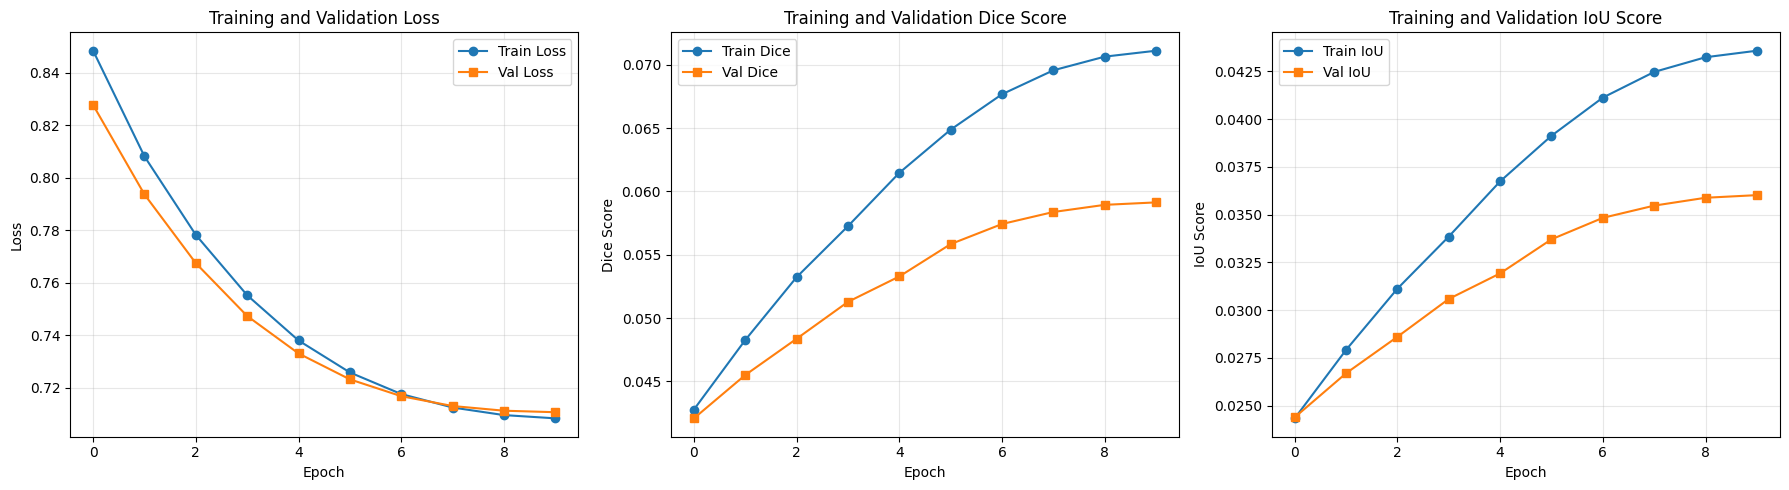

Training history plotted!


In [14]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_iou'], label='Train IoU', marker='o')
axes[2].plot(history['val_iou'], label='Val IoU', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('Training and Validation IoU Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training history plotted!")

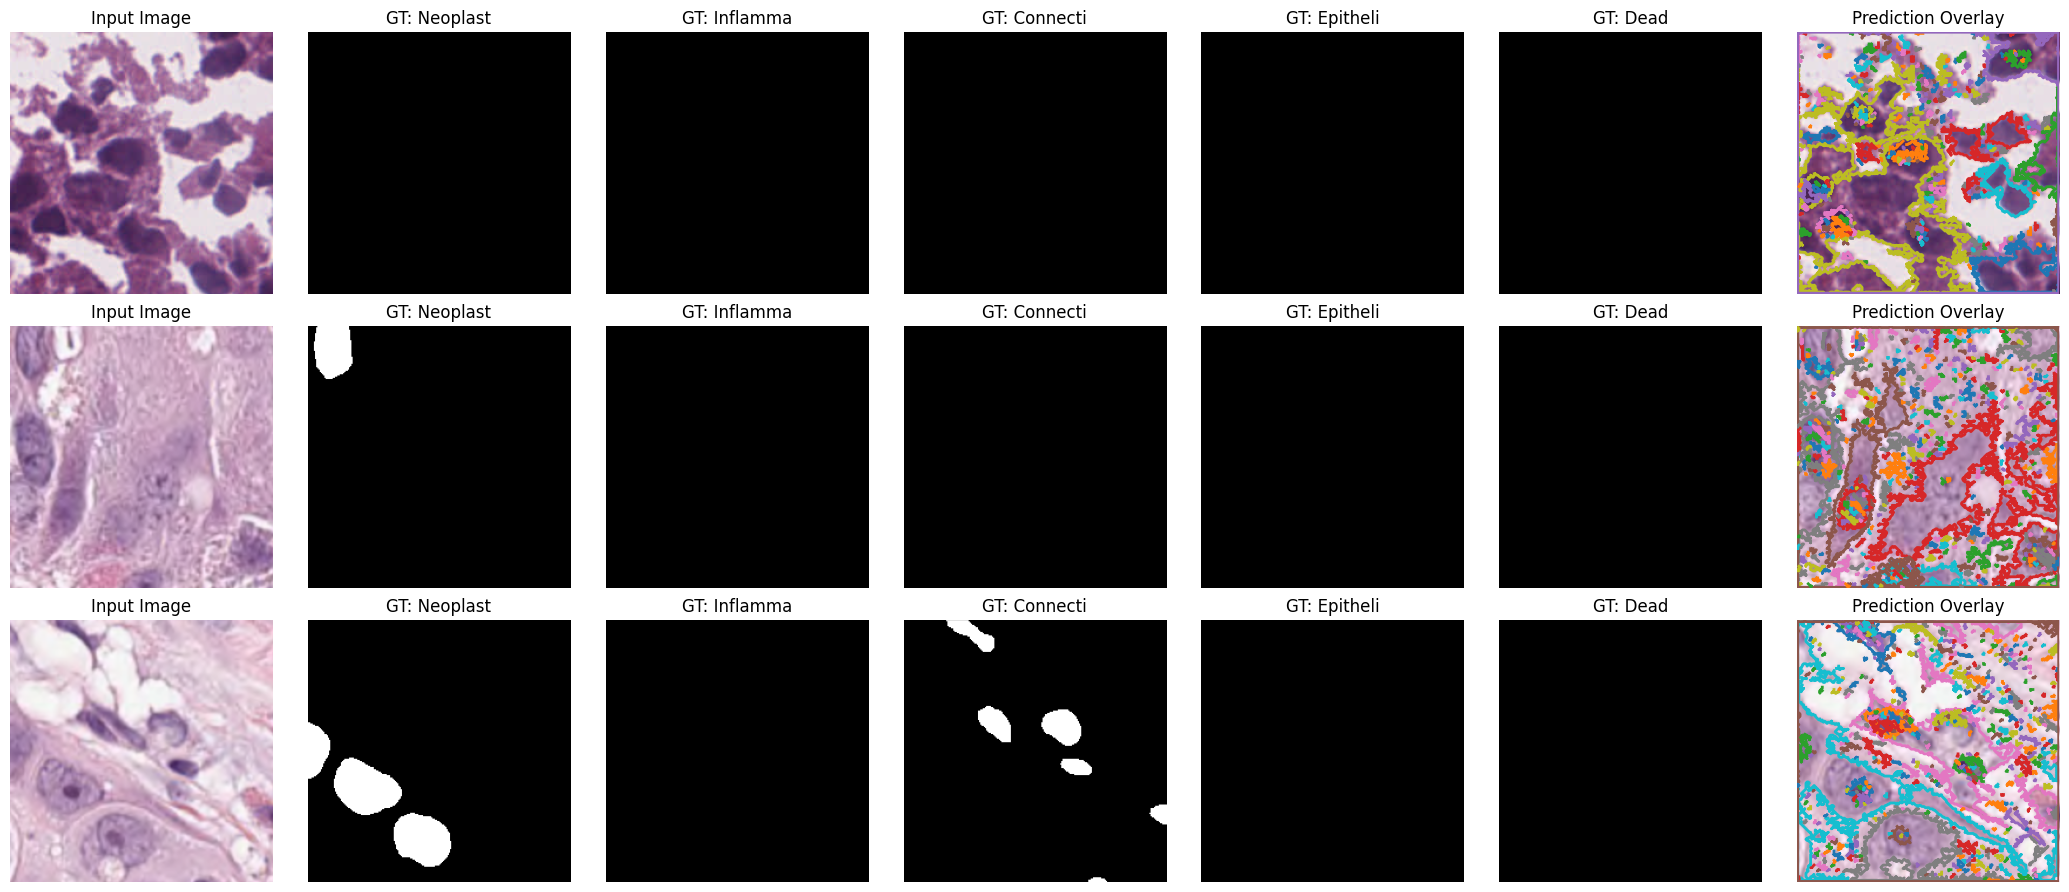

Predictions visualized!


In [15]:
# Visualize sample predictions
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            sample = dataset[idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            gt_masks = sample['masks']  # [5, H, W]
            
            # Get prediction (nnUNet returns list - take first for full resolution)
            outputs = model(image)
            if isinstance(outputs, (list, tuple)):
                pred_masks = torch.sigmoid(outputs[0][0])  # [5, H, W]
            else:
                pred_masks = torch.sigmoid(outputs[0])
            pred_masks = pred_masks.cpu()
            
            # Denormalize image for visualization
            img_display = image[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)
            
            # Plot image
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Plot GT masks
            for j in range(5):
                axes[i, j+1].imshow(gt_masks[j], cmap='gray', vmin=0, vmax=1)
                axes[i, j+1].set_title(f'GT: {class_names[j][:8]}')
                axes[i, j+1].axis('off')
            
            # Overlay prediction
            axes[i, 6].imshow(img_display)
            for j in range(5):
                mask_pred = (pred_masks[j] > 0.5).numpy()
                if mask_pred.sum() > 0:
                    contours = cv2.findContours((mask_pred*255).astype(np.uint8), 
                                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
                    for contour in contours:
                        contour = contour.squeeze()
                        if len(contour) > 2:
                            axes[i, 6].plot(contour[:, 0], contour[:, 1], linewidth=2)
            axes[i, 6].set_title('Prediction Overlay')
            axes[i, 6].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=3)
print("Predictions visualized!")